# Introduction

This notebook provides a comprehensive workflow for cleaning, analyzing, and imputing cryptocurrency futures data. It covers the following key steps:

- **Data Loading and Exploration:**  
    The raw 1-minute BTC futures data is loaded and basic statistics are explored.

- **Data Cleaning:**  
    Missing values and invalid entries are identified and handled to ensure data integrity.

- **Index Continuity and Gap Detection:**  
    The time index is checked for continuity, and missing intervals (gaps) are detected and analyzed.

- **Gap Imputation:**  
    Large gaps in the time series are filled using a Brownian bridge method to generate realistic synthetic data.

- **Final Forward-Filling:**  
    Any remaining small gaps are forward-filled to guarantee a fully continuous 1-minute time series for each contract.

- **Data Persistence:**  
    The cleaned and imputed dataset is saved for future analysis and modeling.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/btc_1m_futures_data.csv')

In [4]:
display(df.head())

,Unnamed: 0,symbol,open,high,low,close,volume
0,2021-12-31 16:00:00,BTC-USDT-220107,47952.0,47973.2,47886.1,47952.9,1420.0
1,2021-12-31 16:01:00,BTC-USDT-220107,47953.6,47958.7,47899.2,47899.2,386.0
2,2021-12-31 16:02:00,BTC-USDT-220107,47898.5,47939.0,47896.3,47916.5,157.0
3,2021-12-31 16:03:00,BTC-USDT-220107,47915.4,47921.7,47867.0,47902.0,118.0
4,2021-12-31 16:04:00,BTC-USDT-220107,47904.6,47915.0,47888.4,47906.2,97.0


In [5]:
len(df)

7424988

### Data Cleaning: Handling Missing Values

Before performing any analysis, it is crucial to ensure the dataset does not contain missing or invalid values that could affect results. In the cell below, we use `df.isna().sum()` to count the number of missing (NaN) values in each column of the DataFrame. This helps identify columns that may require further cleaning or imputation. By understanding the extent and location of missing data, we can make informed decisions on how to handle them, such as dropping rows, filling with default values, or applying more advanced imputation techniques.

In [6]:
df.isna().sum()

Unnamed: 0          0
symbol        2994985
open                0
high                0
low                 0
close               0
volume              0
dtype: int64

### Decision to Drop Rows with Missing Values

In this dataset, each row represents a specific contract (symbol) at a given timestamp. When a row contains a missing value, particularly in the `symbol` column, it is nearly impossible to accurately recover or impute the correct contract information due to the large universe of hundreds of unique contracts. As a result, I decided to drop all rows containing NaN values. This approach ensures data integrity and avoids introducing potentially erroneous or misleading information through imputation.

In [7]:
df.dropna(inplace=True)

### Data Quality Check Function

The `check(df: pd.DataFrame)` function is designed to perform a series of data quality checks on a financial time series DataFrame. It generates a report containing the following diagnostics:

- **NaN Counts:**  
    Counts the number of missing (NaN) values in each column and reports columns with any missing data.

- **Zero Volume Count:**  
    Counts the number of rows where the `volume` column is zero, which may indicate periods of no trading activity or data issues.

- **Invalid High Price Count:**  
    Checks for rows where the `high` price is not greater than or equal to the `open`, `low`, and `close` prices. Such cases are flagged as invalid.

- **Invalid Low Price Count:**  
    Checks for rows where the `low` price is not less than or equal to the `high`, `open`, and `close` prices. These are also flagged as invalid.

The function returns a dictionary summarizing these issues, helping to quickly identify and address potential data integrity problems before further analysis or modeling.

In [8]:
def check(df: pd.DataFrame):
    
    report = {}

    nan_counts = df.isna().sum()
    report['nan_counts'] = nan_counts[nan_counts > 0].to_dict()

    zero_volume_count = (df['volume'] == 0).sum()
    report['zero_volume_count'] = int(zero_volume_count)

    high_check = (
        (df['high'] >= df['open']) &
        (df['high'] >= df['low']) &
        (df['high'] >= df['close'])
    )
    report['invalid_high_count'] = int((~high_check).sum())

    low_check = (
        (df['low'] <= df['high']) &
        (df['low'] <= df['open']) &
        (df['low'] <= df['close'])
    )
    report['invalid_low_count'] = int((~low_check).sum())

    return report


print(check(df))

{'nan_counts': {}, 'zero_volume_count': 0, 'invalid_high_count': 0, 'invalid_low_count': 0}


In [9]:
df.columns = ['timestamp', 'symbol', 'open', 'high', 'low', 'close', 'volume']

In [10]:
pivot_df = df.pivot(index='timestamp', columns='symbol', values=['close', 'volume'])
display(pivot_df.head())

close                                  \
symbol              BTC-USDT-220107 BTC-USDT-220114 BTC-USDT-220121   
timestamp                                                             
2021-12-31 16:00:00         47952.9         48006.6             NaN   
2021-12-31 16:01:00         47899.2         47952.8             NaN   
2021-12-31 16:02:00         47916.5         47963.2             NaN   
2021-12-31 16:03:00         47902.0         47938.7             NaN   
2021-12-31 16:04:00         47906.2         47943.0             NaN   

                                                                     \
symbol              BTC-USDT-220128 BTC-USDT-220204 BTC-USDT-220211   
timestamp                                                             
2021-12-31 16:00:00             NaN             NaN             NaN   
2021-12-31 16:01:00             NaN             NaN             NaN   
2021-12-31 16:02:00             NaN             NaN             NaN   
2021-12-31 16:03:00             NaN             NaN             NaN   
2021-12-31 16:04:00             NaN             NaN             NaN   

                                                                     \
symbol              BTC-USDT-220218 BTC-USDT-220225 BTC-USDT-220304   
timestamp                                                             
2021-12-31 16:00:00             NaN             NaN             NaN   
2021-12-31 16:01:00             NaN             NaN             NaN   
2021-12-31 16:02:00             NaN             NaN             NaN   
2021-12-31 16:03:00             NaN             NaN             NaN   
2021-12-31 16:04:00             NaN             NaN             NaN   

                                     ...          volume                  \
symbol              BTC-USDT-220311  ... BTC-USDT-241206 BTC-USDT-241213   
timestamp                            ...                                   
2021-12-31 16:00:00             NaN  ...             NaN             NaN   
2021-12-31 16:01:00             NaN  ...             NaN             NaN   
2021-12-31 16:02:00             NaN  ...             NaN             NaN   
2021-12-31 16:03:00             NaN  ...             NaN             NaN   
2021-12-31 16:04:00             NaN  ...             NaN             NaN   

                                                                     \
symbol              BTC-USDT-241220 BTC-USDT-241227 BTC-USDT-250103   
timestamp                                                             
2021-12-31 16:00:00             NaN             NaN             NaN   
2021-12-31 16:01:00             NaN             NaN             NaN   
2021-12-31 16:02:00             NaN             NaN             NaN   
2021-12-31 16:03:00             NaN             NaN             NaN   
2021-12-31 16:04:00             NaN             NaN             NaN   

                                                                     \
symbol              BTC-USDT-250110 BTC-USDT-250131 BTC-USDT-250228   
timestamp                                                             
2021-12-31 16:00:00             NaN             NaN             NaN   
2021-12-31 16:01:00             NaN             NaN             NaN   
2021-12-31 16:02:00             NaN             NaN             NaN   
2021-12-31 16:03:00             NaN             NaN             NaN   
2021-12-31 16:04:00             NaN             NaN             NaN   

                                                     
symbol              BTC-USDT-250328 BTC-USDT-250627  
timestamp                                            
2021-12-31 16:00:00             NaN             NaN  
2021-12-31 16:01:00             NaN             NaN  
2021-12-31 16:02:00             NaN             NaN  
2021-12-31 16:03:00             NaN             NaN  
2021-12-31 16:04:00             NaN             NaN  

[5 rows x 324 columns]

### Index Continuity Check and Gap Detection

The code below checks whether the time index of the pivoted DataFrame (`pivot_df`) is continuous at a 1-minute frequency. It performs the following steps:

- **Sorts the Index:**  
    Ensures the DataFrame is sorted by timestamp for accurate comparison.

- **Converts Index to Datetime:**  
    Converts the index to pandas `DatetimeIndex` for time-based operations.

- **Creates a Complete 1-Minute Index:**  
    Generates a full range of timestamps from the minimum to the maximum timestamp at 1-minute intervals.

- **Identifies Missing Timestamps:**  
    Finds timestamps present in the complete index but missing from the DataFrame index, indicating gaps in the data.

- **Reports Gaps:**  
    Prints a message indicating whether the index is continuous or reports the number of missing 1-minute timestamps.

This step is crucial for high-frequency financial data analysis, as missing timestamps can affect downstream calculations and modeling. Detecting and quantifying these gaps allows for appropriate handling, such as imputation or exclusion.

In [11]:
pivot_df_sorted = pivot_df.sort_index()
pivot_df_sorted.index = pd.to_datetime(pivot_df_sorted.index)

full_index = pd.date_range(start=pivot_df_sorted.index.min(), end=pivot_df_sorted.index.max(), freq='1min')

missing = full_index.difference(pivot_df_sorted.index)

if len(missing) == 0:
    print("index is continuous with 1-min frequency, no gaps found.")
else:
    print(f"Found {len(missing)} missing 1-min timestamps in index.")


Found 187790 missing 1-min timestamps in index.


In [12]:
grouped_missing = np.split(missing, np.where(np.diff(missing.astype(np.int64)) != 60_000_000_000)[0] + 1)
group_sizes = [len(g) for g in grouped_missing if len(g) > 0]

### Gap Distribution Analysis

Upon analyzing the missing data, we observed that the majority of missing intervals are concentrated in a small number of large, continuous gaps. These represent extended periods where data is absent, likely due to system outages or exchange-level interruptions. In contrast, there is a long tail of much smaller gaps—typically under 15 minutes (or bars)—that are scattered throughout the dataset. These short gaps may result from sporadic data transmission issues or brief connectivity losses. Understanding this distribution is crucial for selecting appropriate imputation strategies, as large gaps may require more sophisticated methods, while short gaps can often be addressed with simpler techniques or forward-filling.

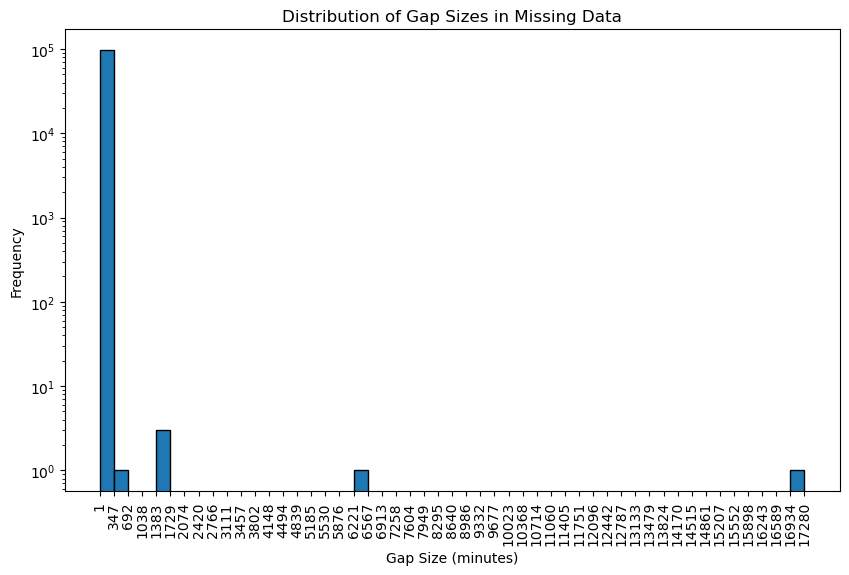

In [14]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(group_sizes, bins=50, edgecolor='k')
plt.xlabel('Gap Size (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Gap Sizes in Missing Data')
plt.yscale('log')
plt.xticks(bins, rotation=90)
plt.show()

In [ ]:
group_sizes.sort(reverse=True)
print("Total number of gaps found:", len(group_sizes))
print("Top 25 largest gaps in minutes:")
for size in group_sizes[:25]:
    print(size)

Total number of gaps found: 96386
Top 25 largest gaps in minutes:
17280
6405
1500
1440
1440
652
180
103
60
59
59
50
48
43
43
37
33
31
30
29
28
27
27
27
26


### Brownian Bridge Gap Imputation Method

The `brownian_bridge_gap` function is designed to fill missing time intervals (gaps) in high-frequency financial time series data, such as cryptocurrency prices. It uses a Brownian bridge process to generate realistic synthetic data for the missing periods.

**Key Steps:**

- **Context Extraction:**  
    The function identifies a window of data before and after the gap to estimate the starting and ending prices, as well as the volatility.

- **Brownian Bridge Construction:**  
    It simulates a log-price path that starts at the log of the last known price before the gap and ends at the log of the first known price after the gap. The path is generated using a Brownian bridge, ensuring a smooth and realistic transition.

- **Price Generation:**  
    The simulated log-prices are exponentiated to obtain the actual prices. Open, high, low, and close prices are constructed for each missing interval, with high and low prices perturbed to reflect realistic price ranges.

- **Volume Imputation:**  
    The function estimates the typical volume profile by time of day and uses it to generate plausible synthetic volumes for the missing intervals.

This method ensures that the imputed data is statistically consistent with the observed data, preserving both price dynamics and volume patterns.

In [ ]:
def brownian_bridge_gap(df, gap_start, gap_end, freq="5min"):
    min_idx = df.index.min()
    max_idx = df.index.max()

    before_start = max(gap_start - pd.Timedelta("5min"), min_idx)
    before_end = max(gap_start - pd.Timedelta(freq), min_idx)
    after_start = min(gap_end + pd.Timedelta(freq), max_idx)
    after_end = min(gap_end + pd.Timedelta("5min"), max_idx)
 
    before_mask = (df.index >= before_start) & (df.index <= before_end)
    after_mask = (df.index >= after_start) & (df.index <= after_end)
    
    before = df.loc[before_mask]
    after = df.loc[after_mask]

    if before.empty:
        before = df.loc[[min_idx]]
    if after.empty:
        after = df.loc[[max_idx]]
    
    P0, PT = np.log(before.close.iloc[-1]), np.log(after.close.iloc[0])  

    logret = pd.concat([np.log(before.close).diff().dropna(), np.log(after.close).diff().dropna()])
    sigma  = np.sqrt((logret**2).mean())

    idx  = pd.date_range(gap_start, gap_end, freq=freq, tz=df.index.tz)
    dt   = (idx - idx[0]).total_seconds() / 60.
    T    = dt[-1]
    Z    = np.random.normal(size=len(idx))               
    W    = np.cumsum(np.insert(Z[:-1], 0, 0)) * np.sqrt(5/60)  
    bridge = P0 + (dt/T)*(PT-P0) + sigma*(W - dt/T*W[-1])
    closes = np.exp(bridge)

    gap = pd.DataFrame(index=idx)
    gap['close'] = closes
    gap['open'] = np.concatenate([[np.exp(P0)], closes[:-1]])
    rng          = np.abs(np.random.normal(scale=sigma*np.sqrt(5/60), size=len(idx)))
    gap['high']  = gap[['open','close']].max(axis=1) * np.exp(rng)
    gap['low']   = gap[['open','close']].min(axis=1) * np.exp(-rng)

    tod_profile = df['volume'].groupby(df.index.time).mean()
    
    gap_times = pd.Index(idx.time)
    available_times = tod_profile.index.intersection(gap_times)
    
    if len(available_times) == 0:
        weights = np.ones(len(idx))
    else:
        weights = np.array([tod_profile.get(t, tod_profile.mean()) for t in gap_times])
    
    weights = weights / weights.sum()
    total_vol = 0.5 * (before.volume.mean() + after.volume.mean()) * len(idx) / len(before)
    gap['volume'] = np.random.poisson(weights * total_vol)

    return gap

In [ ]:
imputed_df = pd.DataFrame()

for symbol in df['symbol'].unique():
    symbol_df = df[df['symbol'] == symbol]
    symbol_df.set_index('timestamp', inplace=True)
    symbol_df.index = pd.to_datetime(symbol_df.index)
    symbol_df.sort_index(inplace=True)

    symbol_full_index = pd.date_range(start=symbol_df.index.min(), end=symbol_df.index.max(), freq='1min')
    missing_times = symbol_full_index.difference(symbol_df.index)

    if len(missing_times) > 0:
        missing_groups = np.split(missing_times, np.where(np.diff(missing_times.astype(np.int64)) != 60_000_000_000)[0]+1)
        for group in missing_groups:
            if len(group) <= 15:
                continue
            gap_start = group[0]
            gap_end = group[-1]
            gap_df = brownian_bridge_gap(symbol_df, gap_start, gap_end, freq="1min")
            gap_df['symbol'] = symbol

            symbol_df = pd.concat([symbol_df, gap_df], axis=0)
        symbol_df.sort_index(inplace=True)
        
        imputed_df = pd.concat([imputed_df, symbol_df], axis=0)


In [22]:
imputed_df.index.name = 'timestamp'

In [25]:
imputed_df.reset_index(inplace=True)

In [24]:
display((imputed_df.head()))

,symbol,open,high,low,close,volume
timestamp,,,,,,
2021-12-31 16:00:00,BTC-USDT-220107,47952.0,47973.2,47886.1,47952.9,1420.0
2021-12-31 16:01:00,BTC-USDT-220107,47953.6,47958.7,47899.2,47899.2,386.0
2021-12-31 16:02:00,BTC-USDT-220107,47898.5,47939.0,47896.3,47916.5,157.0
2021-12-31 16:03:00,BTC-USDT-220107,47915.4,47921.7,47867.0,47902.0,118.0
2021-12-31 16:04:00,BTC-USDT-220107,47904.6,47915.0,47888.4,47906.2,97.0


### Final Imputation and Forward-Filling

In this step, we construct the final imputed DataFrame (`imputed_df_final`) by ensuring that each symbol's time series is continuous at a 1-minute frequency. For each unique symbol:

- **Subset and Indexing:**  
    The data for each symbol is extracted and the `timestamp` column is converted to a datetime index.

- **Resampling and Forward-Filling:**  
    The data is resampled to a 1-minute frequency using `.resample('1min').ffill()`, which fills any remaining missing timestamps by carrying forward the last available observation. This ensures that the time series for each symbol has no gaps.

- **Concatenation:**  
    The processed data for each symbol is concatenated into the final DataFrame.

This approach guarantees a fully continuous 1-minute time series for all symbols, which is essential for downstream analysis and modeling that require regularly spaced data.

In [ ]:
imputed_df_final = pd.DataFrame()

symbols = imputed_df_final['symbol'].unique()

for symbol in symbols:
    symbol_df = df[df['symbol'] == symbol].copy()
    symbol_df['timestamp'] = pd.to_datetime(symbol_df['timestamp'])
    symbol_df.set_index('timestamp', inplace=True)
    
    symbol_df = symbol_df.resample('1min').ffill()

    imputed_df_final = pd.concat([imputed_df_final, symbol_df], axis=0)

### Data Persistence for Future Use

In [18]:
imputed_df.to_csv('../data/btc_1m_futures_data_imputed.csv', index=True)